# Section D3 - Graphing with Pandas (and Matplotlib)

Feedback: https://forms.gle/Le3RAsMEcYqEyswEA

## DataFrame.plot
The built-in pandas plotting is based on matplotlib by default and gives a simple inteface to make a lot of plot types. You'll notice that there are a couple of variations of the plot commands that work fairly interchangably:
* `df.plot.box(by='dayofyear')`
* `df.plot(kind='box', by='dayofyear')`
* `df.boxplot(by='dayofyear')`

df.plot.box and df.plot(kind='box') are equivelant and use the pandas plot wrapper to call plt.boxplot. df.boxplot is a more direct call to plt.boxplot - and not all plot types have this call available directly in the dataframe. In any case, you'll notice that plt.box and plt.boxplot don't have a "by" argument.  There's a bit of code in the pandas wrapper that the above three meuthods use to groupby the data for you. There's a comparison with the plt.box function in the boxplot example below.

The plot function built into the Pandas DataFrame object works with matplotlib to generate plots for you using a few standard arguments:

* **data** is the dataframe object to work on.  If you call df.plot, this is implied, and if you call pd.DataFrame.plot(data=df, ...) it must be given as an argument. 
* **x** is a label or position, defaulting to None.
* **y** is a label, position, or list of balel, positions, defaulting to None.
* **kind** is the type of plot to make:  line, bar, hist, scatter, etc...  

As well as a bunch of more detailed options for the plot axis, subplots, style options etc.  Read over the documintation for a few min to see what options are available: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

Many of the arguments you can pass into df.plot can also be called in some form against `plt`

**Let's make a few types of charts!**  We'll start by pulling some data that we can work with. This is from the USGS gauging station at Toland Landing in Rio Vista, CA.  This data clearly shows the tide, includes a lot of parameters to play with.

Note that we're importing numpy and pyplot here, as these are needed in a couple examples below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_url = 'https://waterservices.usgs.gov/nwis/iv/?sites=11455485&startDT=2024-09-15T20:55:29.967-07:00&endDT=2024-10-15T20:55:29.967-07:00&format=rdb'
tol_all= pd.read_csv(data_url, sep='\t', comment='#', header=0)
tol_all = tol_all.drop(tol_all.index[0])

# If you open the above url in your web browser, you'll see information on what the numeric pcodes represent.

# regression/scatter of specific conductivity and salinity
# time series with nitrate and chlorophyll; ph,do and chlorophyll...
# Boxplot of daily temperature

In [2]:
cols = {'datetime': 'datetime',
        '288768_00065': 'gage height ft',
        '288432_00010': 'temperature C',
        '288434_00095': 'specific conductance uS/cm',
        '291459_00300': 'dissolved oxygen mg/L',
        '291463_00400': 'pH',
        '304254_32295': 'dom ug/L',
        '305297_90860': 'salinity ppt',
        '291460_32316': 'fchl mg/L'  # chlorophyll
        } 
tol = tol_all[cols.keys()].rename(columns=cols)
tol['datetime'] = pd.to_datetime(tol['datetime'])
tol = tol.set_index('datetime')
tol = tol.apply(pd.to_numeric, errors='coerce')
print(tol.head())

                     gage height ft  temperature C  \
datetime                                             
2024-09-15 20:00:00            5.37           20.4   
2024-09-15 20:15:00            5.58           20.4   
2024-09-15 20:30:00            5.75           20.3   
2024-09-15 20:45:00            5.99           20.3   
2024-09-15 21:00:00            6.21           20.3   

                     specific conductance uS/cm  dissolved oxygen mg/L   pH  \
datetime                                                                      
2024-09-15 20:00:00                       159.0                    8.6  7.8   
2024-09-15 20:15:00                       165.0                    8.6  7.8   
2024-09-15 20:30:00                       165.0                    8.6  7.8   
2024-09-15 20:45:00                       166.0                    8.6  7.8   
2024-09-15 21:00:00                       166.0                    8.6  7.9   

                     dom ug/L  salinity ppt  
datetime             

## Time series
Since the datetime values in our df are set as the index, plot will automatically use them for the x axis.   We specify which column we want to use for the y axis, and the plot type, and we get a decent looking graph:

<Axes: xlabel='datetime'>

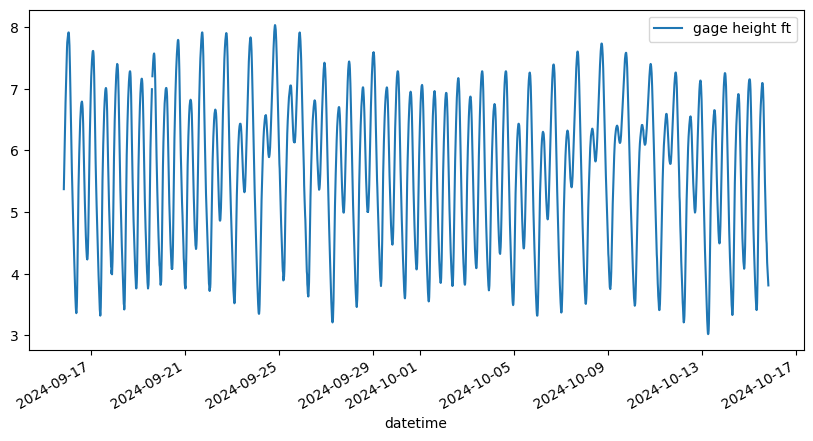

In [40]:
tol.plot(y='gage height ft', kind='line')

What a nice view showing impact of the tides on the gage height...  we can see the high-highs, low-highs, high-lows, and low-lows!

#### *Exercise*:
Set a few plot parameters to inprove the plot:
* title, xlabel, ylabel
* use figsize to make the plot wider.  Try (10,5) to start.
* change y='...' to a list y=['...', '...'] and add the specific conductance column
* sharing an axis between gauge height and specific conductance doesn't work very well, so set secondary_y='specific conductance uS/cm'.  
What migh twe say aobut the tide cycle at this station, seen via gauge height, and the conductance? 

## Scatter
Scatter plots are useful for visualizing correlation, distribution, and clustering of data.  Let's see if there's a relatinship between salinity and conductance in our data:

<Axes: xlabel='salinity ppt', ylabel='specific conductance uS/cm'>

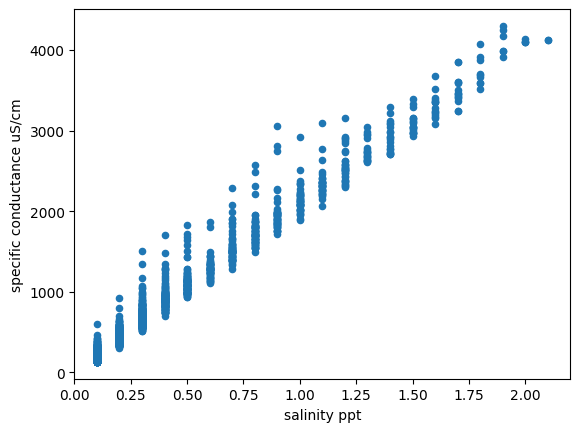

In [62]:
# tol.plot(kind='scatter', y='specific conductance uS/cm', x='salinity ppt')
tol.plot.scatter(y='specific conductance uS/cm', x='salinity ppt')

#### *Exercise*:
Let's make a few cosmetic changes:
* Set the color to green with `c='green'`
* set the point size and transparency with `s=50, alpha=0.7`
* set the title and axis labels if you like.

Let's see what happens if we use another column to set the color of our points.
* add `cmap='viridis'` to your plot command
* set `c=tol['temperature C']` in the plot commmand
* also try `c=tol['gage height ft']`

What observations can we make about the relationships between temperature, gage height, and salinity?

## Overlaying a Regression Line
When we run a cell and make a plot, matplotlib creates a figure that the plot is rendered on.  We can follow with a second plot in the same cell and it will be drawn on the same figure. This can be useful to add a regression line over our scatter plot.

There are some Nan values in the conductance and salinity columns in our dataframe, so we need to use dropna to clean those up before using np.polyfit.  So we create a tol_cleaned dataframe.

Then we generate our y values as `regression_line` using our x values with the slope and intercept... this is a y=mx+b equation, but since x is a series, the mutiplication and addition operations are broadcast through the series and we get a series result that we save as regression_line.  

slope: 2160.6322894868645 intercept: -19.685058556168173


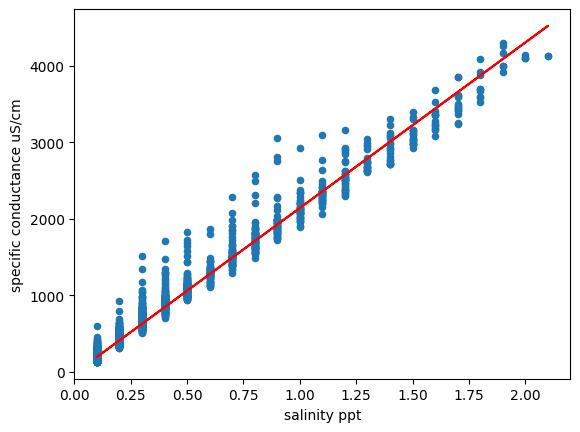

In [8]:
# Scatter plot
tol.plot(kind='scatter', y='specific conductance uS/cm', x='salinity ppt')

# Fit a regression line
tol_cleaned = tol[['specific conductance uS/cm', 'salinity ppt']].dropna()
y = tol_cleaned['specific conductance uS/cm']
x = tol_cleaned['salinity ppt']
slope, intercept = np.polyfit(x, y, 1)
print('slope:', slope, 'intercept:', intercept)

# Generate line points and plot it over the scatter plot
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='red')


#### *Exercise*
An alternative way to generate a regressiono line, rather than generating a list of points on it to plot, is to use plt.axline.  axline() accepts arguments xy1, a point the line passes through, and either a second point xy2 or the slope.
* Comment out the two lines generating and plotting regression_line
* Add a plt.axline() line
* set xy1=(0, intercept)
* set slope=slope
* set color='r'
And re-run the cell. Docs on axline: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axline.html

As mentioned above, both plots share the same figure.  We can generate two separate plots by adding `plt.show()` before the second plt.plot command.  Try doing this to see the result.

## Box and Whiskers Plot
As mentionMatplotlib has two functinos for this: plt.boxplot and plt.box.  Boxplot works on a dataframe by taking a list of columns to plot as separate boxes, e.g. `df.plot(kind='boxplot', columns=['A', 'B', 'C'])`, and box works on a series object and accepts another series to group the data from the first series on

For our plot, let's group our 15 minute data by day and show the temperature each day.  

temperature C    Axes(0.125,0.11;0.775x0.77)
dtype: object

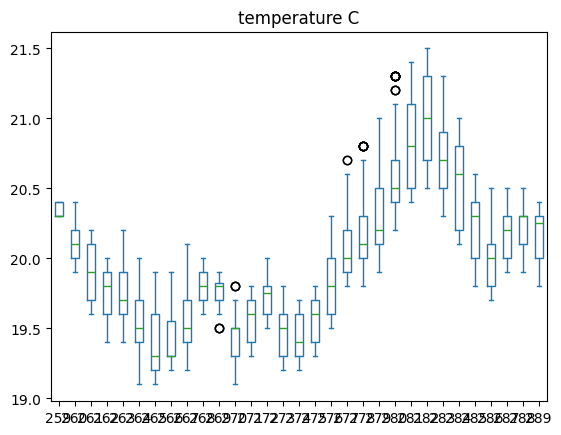

In [68]:
tol['dayofyear'] = tol.index.dayofyear

# These three are all pretty much equivelant:
tol[['dayofyear', 'temperature C']].plot.box(by='dayofyear')
# tol[['dayofyear', 'temperature C']].boxplot(by='dayofyear')
# tol[['dayofyear', 'temperature C']].plot(kind='box', by='dayofyear')

# An example using pyplot directly:
# grouped_data = tol.groupby('dayofyear')['temperature C'].apply(list)
# plt.boxplot(grouped_data, tick_labels=grouped_data.index)


#### *Exercise*
* The labels are kind of hard to see... use the `figsize` argument to make the plot wider and the `rot` argument to rotate the labels. 
* Day of year works, but isn't very understandable.  The dataframe index is made up of datetime objects, so we can use the strftime function built into datetime objects to get a formatted date.  Use the following line for a month_day column and update the plot command to use it instead of dayofyear:

    tol['month_day'] = tol.index.strftime('%B %d')



Just for fun, we can sort of graph the data used to generate a simplified boxplot using 

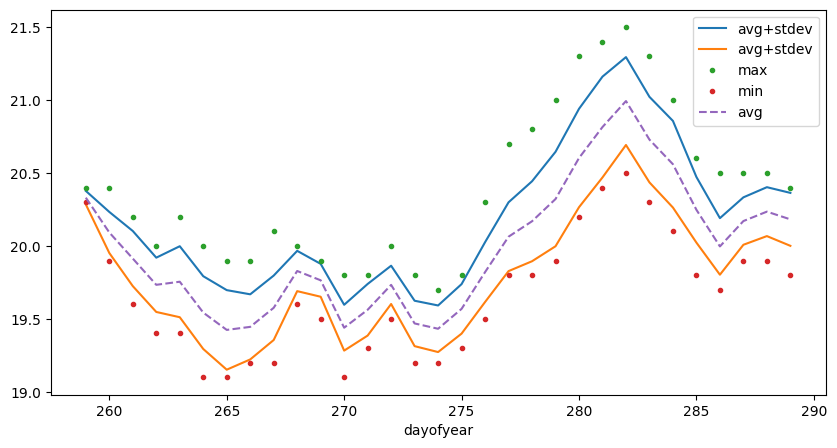

In [55]:
min_max_field = 'temperature C'
gate_max = tol.groupby('dayofyear')[min_max_field].apply(np.max)
gate_min = tol.groupby('dayofyear')[min_max_field].apply(np.min)
gate_avg = tol.groupby('dayofyear')[min_max_field].apply(np.mean)
stdev = tol.groupby('dayofyear')[min_max_field].apply(np.std)

gate_max.plot(label='max', figsize=(10, 5), style='.')
gate_min.plot(label='min', style='.')
gate_avg.plot(label='avg', style='--')
(gate_avg + stdev).plot(label='avg+stdev')
(gate_avg - stdev).plot(label='avg+stdev')
plt.legend()

## Histogram
We can use a histogram to "bucket" values and see which buckets are most common. Let's try this with the temperature data:

<Axes: ylabel='Frequency'>

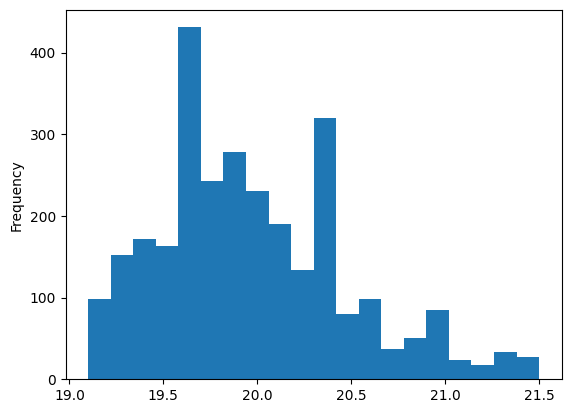

In [82]:
# histogram
tol['temperature C'].plot.hist(bins=20)

# group by day of year and generate the histogram again:
# tol.groupby('dayofyear')['temperature C'].apply(np.mean).plot.hist(bins=20)


## Multi Axis

We need to pay more attion to matplotlib for multi-axis plots.  Let's say we wanted do show plots of several parameters on separate graphs - we can define subplots using plt.subplots and tell each plot we make which axis to draw on.  It's a convention to call multiple axis "axs".  fig, axs = plt.subplots... is equiv to fig, (ax0, ax1, ...) = plt.subplots...

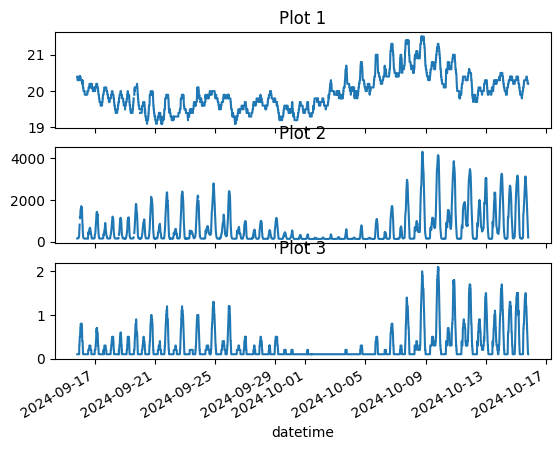

In [84]:
fig, axs = plt.subplots(3)
tol['temperature C'].plot(ax=axs[0])
tol['specific conductance uS/cm'].plot(ax=axs[1])
tol['salinity ppt'].plot(ax=axs[2])

for n, ax in enumerate(axs):
    ax.set_title(f'Plot {n+1}')
    ax.label_outer()



## Histogram

## Heatmap

## Multiple Plots